# Final Project Report

* Class: DS 5100
* Student Name: Ryan Harrington
* Student Net ID: crf6zj
* This URL: https://github.com/rtharrin/DS5100-crf6zj-FinalProject/blob/main/junk/DS51200_FinalProjectTemplate.ipynb

# Instructions

Follow the instructions in the Final Project isntructions notebook and put evidence of your work in this notebook.

Total points for each subsection under **Deliverables** and **Scenarios** are given in parentheses.

Breakdowns of points within subsections are specified within subsection instructions as bulleted lists.

This project is worth **50 points**.

# Deliverables

## The Monte Carlo Module (10)

- URL included, appropriately named (1).
- Includes all three specified classes (3).
- Includes at least all 12 specified methods (6; .5 each).

Put the URL to your GitHub repo here.

Repo URL: https://github.com/rtharrin/DS5100-crf6zj-FinalProject

Paste a copyy of your module here.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

In [1]:
# A code block with your classes.
import numpy as np
import pandas as pd
from itertools import combinations_with_replacement, permutations
from collections import Counter

#Die Class
class Die:
    def __init__(self,faces: np.array):
        """Initialization method, ensure that input faces is a NumPy array of distinct string/numbers.
        Defaults all weights to 1 for each face.
        """
        #first make sure faces is a NumPy array
        if type(faces) != np.ndarray:
            raise TypeError("Parameter faces must be a NumPy array")
        
              
        #Make sure the values of faces are unique
        if faces.size != np.unique(faces).size:
            raise ValueError("The values of input faces must be unique")
        
        base_weight = [1.0]*faces.size
        self.df = pd.DataFrame(index=faces, data={'Weight':base_weight})
        
    def change_weight(self,fval,weight):
        """Method to change the weight of a single side.  
        Must ensure the fval is a valid index and the weight can be cast as numeric
        Takes input fval representing the face value and weight representing the new weight.
        """
        #make sure it is a valid face name
        if fval not in self.df.index:
            raise IndexError("Your fval is not a valid face name")
        #Make sure the weight can be cast to a numeric
        try:
            float(weight)
        except ValueError :
            raise TypeError("weight must be able to be converted to a number")
            
        self.df.loc[fval,'Weight'] = float(weight)
        
    def roll_die(self,num_rolls=1):
        """Method to roll the dice, returns a list of results. 
        Takes one optional parameter, num_rolls, identifying number of rolls desired, defaults to 1 roll.
        results are not stored internally"""
        tmp = list(self.df.sample(n=num_rolls,replace=True,weights=self.df['Weight']).index)
        return tmp
    
    def show_die(self):
        """Method returning the data frame representing the die"""
        return self.df
    
#Game Class

class Game:
    """Game class expecting a list of die.  Rolls the dies numerous times and stores results in private outcome object.
    Game objects only keep results of most recent play.
    """
    
    def __init__(self,dice):
        """Initialization method, takes a list of die objects, dice."""
        self.dice=dice
    
    def play(self, num_rolls):
        """Takes the number of rolls as only parameter, num_rolls.  
        Creates/updates the private outcome object with the results"""
        result_d = dict()
        for i, die in enumerate(self.dice):
            vals = die.roll_die(num_rolls)
            result_d[i] = vals
            
        # Create a DataFrame from the dictionary of results
        self._outcome = pd.DataFrame(result_d)
        self._outcome.index.name = 'Roll_Num'
        self._outcome.columns.name = 'Die_Num'


        
    def show_outcome(self,view="wide"):
        """Method returning the result. Options include wide and narrow, default value of wide. 
        Narrow is a stacked version of the wide format with MultiIndex.
        """
        if view.upper() == "WIDE":
            return self._outcome
        elif view.upper() == "NARROW":
            # Stack the columns to create a MultiIndex with roll number and die number
            narrow_df = self._outcome.stack().reset_index()
            # Rename columns appropriately
            narrow_df.columns = ['Roll Number', 'Die Number', 'Outcome']
            # Set MultiIndex using roll number and die number
            narrow_df = narrow_df.set_index(['Roll Number', 'Die Number'])
            return narrow_df
        else:
            raise ValueError("view must be either wide or narrow")

# Analyzer Class

class Analyzer:
    """
    A class to analyze the results of a dice game.
    Takes the results of a single game and computes various descriptive statistical properties about it.
    """
    
    def __init__(self, game):
        """
        Initialize an Analyzer with a Game object.
        Throws error is input, game, is not a Game object.
        """
        if not isinstance(game, Game):
            raise ValueError("Input must be a Game object")
        self.game = game
        
    def jackpot(self):
        """ Compute how many times the game resulted in all faces being the same.
        Takes no input and returns the number of jackpots as a number.
        """
        # Get the results in wide format
        results = self.game.show_outcome("wide")
        # Check each row (roll) to see if all values in that roll are the same
        jackpots = results.apply(lambda x: x.nunique() == 1, axis=1)
        return int(jackpots.sum())
    
    def face_counts_per_roll(self):
        """
        Compute how many times each face appears in each roll.
        The result is a DataFrame.
        """
        # Get results in wide format
        results = self.game.show_outcome("wide")
        # Get unique faces from the results
        all_faces = pd.unique(results.values.ravel())
        
        # Create a new dataframe to store counts
        counts_df = pd.DataFrame(index=results.index)
        
        # For each face, count occurrences in each roll
        for face in all_faces:
            counts_df[face] = results.apply(lambda x: (x == face).sum(), axis=1)
            
        return counts_df
    
    def combo_count(self):
        """
        Compute the distinct combinations of faces rolled along with their counts.
        Returns a DataFrame with MultiIndex of distinct combinations and a column for the associated counts
        """
        # Get results in wide format
        results = self.game.show_outcome("wide")
        
        # Convert each roll to a sorted tuple (order-independent)
        combos = results.apply(lambda x: tuple(sorted(x)), axis=1)
        
        # Count occurrences of each combination
        combo_counts = Counter(combos)
        
        # Convert to dataframe with MultiIndex
        df = pd.DataFrame.from_dict(combo_counts, orient='index', columns=['Count'])
        df.index = pd.MultiIndex.from_tuples(df.index)
        
        return df
    
    def permutation_count(self):
        """
        Compute the distinct permutations of faces rolled along with their counts.
        Permutations are order-dependent and may contain repetitions.
        
        Returns a dataframe with MultiIndex of distinct permutations and a column for the associated counts
        """
        # Get results in wide format
        results = self.game.show_outcome("wide")
        
        # Convert each roll to a tuple (maintaining order)
        perms = results.apply(lambda x: tuple(x), axis=1)
        
        # Count occurrences of each permutation
        perm_counts = Counter(perms)
        
        # Convert to dataframe with MultiIndex
        df = pd.DataFrame.from_dict(perm_counts, orient='index', columns=['Count'])
        df.index = pd.MultiIndex.from_tuples(df.index)
        
        return df


## Unitest Module (2)

Paste a copy of your test module below.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

- All methods have at least one test method (1).
- Each method employs one of Unittest's Assert methods (1).

In [51]:
import unittest
import numpy as np
import pandas as pd
from montecarlo.simulator import Die
from montecarlo.simulator import Game
from montecarlo.simulator import Analyzer

class TestDie(unittest.TestCase):
    """Unit tests for the Die class"""
    
    def setUp(self):
        """Set up test fixtures"""
        self.faces = np.array(['A', 'B', 'C', 'D', 'E', 'F'])
        self.die = Die(self.faces)
        
    def test_init_valid(self):
        """Test initialization with valid input"""
        self.assertIsInstance(self.die.show_die(), pd.DataFrame)
        self.assertEqual(len(self.die.show_die()), len(self.faces))
        
    def test_init_invalid_type(self):
        """Test initialization with invalid input type"""
        with self.assertRaises(TypeError):
            Die([1, 2, 3, 4, 5, 6])  # List instead of numpy array
            
    def test_init_non_unique(self):
        """Test initialization with non-unique faces"""
        with self.assertRaises(ValueError):
            Die(np.array(['A', 'B', 'C', 'C', 'D']))  # Duplicate face
            
    def test_change_weight_valid(self):
        """Test changing weight with valid inputs"""
        self.die.change_weight('A', 2.0)
        self.assertEqual(self.die.show_die().loc['A', 'Weight'], 2.0)
        
    def test_change_weight_invalid_face(self):
        """Test changing weight with invalid face"""
        with self.assertRaises(IndexError):
            self.die.change_weight('X', 2.0)  # Face doesn't exist
            
    def test_change_weight_invalid_weight(self):
        """Test changing weight with invalid weight type"""
        with self.assertRaises(TypeError):
            self.die.change_weight('A', 'heavy')  # Non-numeric weight
            
    def test_roll_die_single(self):
        """Test rolling die once"""
        result = self.die.roll_die()
        self.assertEqual(len(result), 1)
        self.assertIn(result[0], self.faces)
        
    def test_roll_die_multiple(self):
        """Test rolling die multiple times"""
        n_rolls = 5
        result = self.die.roll_die(n_rolls)
        self.assertEqual(len(result), n_rolls)
        self.assertTrue(all(face in self.faces for face in result))
        
    def test_show_die(self):
        """Test showing die state"""
        df = self.die.show_die()
        self.assertIsInstance(df, pd.DataFrame)
        self.assertTrue('Weight' in df.columns)
        self.assertEqual(len(df), len(self.faces))
        self.assertTrue(all(face in df.index for face in self.faces))

class TestGame(unittest.TestCase):
    """Unit tests for the Game class"""
    
    def setUp(self):
        """Set up test fixtures"""
        # Create two similar dice
        faces = np.array(['A', 'B', 'C', 'D', 'E', 'F'])
        self.die1 = Die(faces)
        self.die2 = Die(faces)
        self.dice_list = [self.die1, self.die2]
        self.game = Game(self.dice_list)
        
    def test_init(self):
        """Test game initialization"""
        self.assertEqual(len(self.game.dice), 2)
        self.assertIsInstance(self.game.dice[0], Die)
        self.assertIsInstance(self.game.dice[1], Die)
        
    def test_play(self):
        """Test playing the game"""
        n_rolls = 3
        self.game.play(n_rolls)
        results = self.game.show_outcome()
        
        # Check if results DataFrame has correct shape and format
        self.assertIsInstance(results, pd.DataFrame)
        self.assertEqual(len(results), n_rolls)  # Correct number of rolls
        self.assertEqual(len(results.columns), len(self.dice_list))  # Correct number of dice
        
    def test_show_outcome_wide(self):
        """Test showing results in wide format"""
        self.game.play(3)
        results = self.game.show_outcome("wide")
        
        # Check wide format properties
        self.assertIsInstance(results, pd.DataFrame)
        self.assertEqual(len(results.columns), len(self.dice_list))
        
    def test_show_outcome_narrow(self):
        """Test showing results in narrow format"""
        self.game.play(3)
        results = self.game.show_outcome("narrow")
        
        # Check narrow format properties
        self.assertIsInstance(results, pd.DataFrame)
        self.assertEqual(len(results.columns), 1)  # Should have single column for outcomes
        self.assertTrue(isinstance(results.index, pd.MultiIndex))  # Should have MultiIndex
        
    def test_show_outcome_invalid(self):
        """Test showing results with invalid format"""
        self.game.play(3)
        with self.assertRaises(ValueError):
            self.game.show_outcome("invalid_format")

class TestAnalyzer(unittest.TestCase):
    """Unit tests for the Analyzer class"""
    
    def setUp(self):
        """Set up test fixtures"""
        # Create a game with two dice
        faces = np.array(['A', 'B', 'C', 'D', 'E', 'F'])
        die1 = Die(faces)
        die2 = Die(faces)
        self.game = Game([die1, die2])
        self.game.play(10)  # Play 10 rolls
        self.analyzer = Analyzer(self.game)
        
    def test_init_valid(self):
        """Test analyzer initialization with valid game object"""
        self.assertIsInstance(self.analyzer.game, Game)
        
    def test_init_invalid(self):
        """Test analyzer initialization with invalid input"""
        with self.assertRaises(ValueError):
            Analyzer("not a game object")
            
    def test_jackpot(self):
        """Test jackpot counting method"""
        jackpots = self.analyzer.jackpot()
        self.assertIsInstance(jackpots, int)
        self.assertTrue(jackpots >= 0)
        
    def test_face_counts_per_roll(self):
        """Test face counts per roll method"""
        counts = self.analyzer.face_counts_per_roll()
        
        # Verify output format
        self.assertIsInstance(counts, pd.DataFrame)
        self.assertEqual(len(counts), 10)  # Should have 10 rolls
        
        # Verify that sum of counts per row equals number of dice
        row_sums = counts.sum(axis=1)
        self.assertTrue(all(row_sums == 2))  # 2 dice per roll
        
    def test_combo_count(self):
        """Test combination counting method"""
        combos = self.analyzer.combo_count()
        
        # Verify output format
        self.assertIsInstance(combos, pd.DataFrame)
        self.assertTrue(isinstance(combos.index, pd.MultiIndex))
        self.assertEqual(len(combos.columns), 1)  # Should have one 'Count' column
        
        # Verify counts are non-negative
        self.assertTrue(all(combos['Count'] > 0))
        
    def test_permutation_count(self):
        """Test permutation counting method"""
        perms = self.analyzer.permutation_count()
        
        # Verify output format
        self.assertIsInstance(perms, pd.DataFrame)
        self.assertTrue(isinstance(perms.index, pd.MultiIndex))
        self.assertEqual(len(perms.columns), 1)  # Should have one 'Count' column
        
        # Verify counts are non-negative
        self.assertTrue(all(perms['Count'] > 0))
        
        # Verify permutations count is >= combinations count
        # (since order matters in permutations)
        self.assertTrue(len(perms) >= len(self.analyzer.combo_count()))

if __name__ == '__main__':
    unittest.main(argv=[''], verbosity=2, exit=False)

test_combo_count (__main__.TestAnalyzer.test_combo_count)
Test combination counting method ... ok
test_face_counts_per_roll (__main__.TestAnalyzer.test_face_counts_per_roll)
Test face counts per roll method ... ok
test_init_invalid (__main__.TestAnalyzer.test_init_invalid)
Test analyzer initialization with invalid input ... ok
test_init_valid (__main__.TestAnalyzer.test_init_valid)
Test analyzer initialization with valid game object ... ok
test_jackpot (__main__.TestAnalyzer.test_jackpot)
Test jackpot counting method ... ok
test_permutation_count (__main__.TestAnalyzer.test_permutation_count)
Test permutation counting method ... ok
test_change_weight_invalid_face (__main__.TestDie.test_change_weight_invalid_face)
Test changing weight with invalid face ... ok
test_change_weight_invalid_weight (__main__.TestDie.test_change_weight_invalid_weight)
Test changing weight with invalid weight type ... ok
test_change_weight_valid (__main__.TestDie.test_change_weight_valid)
Test changing weight w

## Unittest Results (3)

Put a copy of the results of running your tests from the command line here.

Again, paste as text using triple backticks.

- All 12 specified methods return OK (3; .25 each).

## Import (1)

Import your module here. This import should refer to the code in your package directory.

- Module successuflly imported (1).

In [8]:
# e.g. import montecarlo.montecarlo 
import montecarlo.simulator as s

## Help Docs (4)

Show your docstring documentation by applying `help()` to your imported module.

- All methods have a docstring (3; .25 each).
- All classes have a docstring (1; .33 each).

In [9]:
 help(s)

Help on module montecarlo.simulator in montecarlo:

NAME
    montecarlo.simulator

CLASSES
    builtins.object
        Analyzer
        Die
        Game
    
    class Analyzer(builtins.object)
     |  Analyzer(game)
     |  
     |  A class to analyze the results of a dice game.
     |  Takes the results of a single game and computes various descriptive statistical properties about it.
     |  
     |  Methods defined here:
     |  
     |  __init__(self, game)
     |      Initialize an Analyzer with a Game object.
     |      Throws error is input, game, is not a Game object.
     |  
     |  combo_count(self)
     |      Compute the distinct combinations of faces rolled along with their counts.
     |      Returns a DataFrame with MultiIndex of distinct combinations and a column for the associated counts
     |  
     |  face_counts_per_roll(self)
     |      Compute how many times each face appears in each roll.
     |      The result is a DataFrame.
     |  
     |  jackpot(self)


## `README.md` File (3)

Provide link to the README.md file of your project's repo.

- Metadata section or info present (1).
- Synopsis section showing how each class is called (1). (All must be included.)
- API section listing all classes and methods (1). (All must be included.)

URL:https://github.com/rtharrin/DS5100-crf6zj-FinalProject/blob/main/README.md

## Successful installation (2)

Put a screenshot or paste a copy of a terminal session where you successfully install your module with pip.

If pasting text, use a preformatted text block to show the results.

- Installed with `pip` (1).
- Successfully installed message appears (1).

# Scenarios

Use code blocks to perform the tasks for each scenario.

Be sure the outputs are visible before submitting.

## Scenario 1: A 2-headed Coin (9)

Task 1. Create a fair coin (with faces $H$ and $T$) and one unfair coin in which one of the faces has a weight of $5$ and the others $1$.

- Fair coin created (1).
- Unfair coin created with weight as specified (1).

In [43]:
faces = np.array(['H','T'])
fair=s.Die(faces)
unfair=s.Die(faces)
unfair.change_weight("H",5)
fair.show_die()


,Weight
H,1.0
T,1.0


In [44]:
unfair.show_die()

,Weight
H,5.0
T,1.0


Task 2. Play a game of $1000$ flips with two fair dice.

- Play method called correclty and without error (1).

In [22]:
game1=s.Game([fair,fair])
game1.play(1000)
game1.show_outcome()

Die_Num,0,1
Roll_Num,,
0,H,T
1,T,H
2,T,H
3,T,T
4,H,H
...,...,...
995,T,T
996,H,H
997,T,T


Task 3. Play another game (using a new Game object) of $1000$ flips, this time using two unfair dice and one fair die. For the second unfair die, you can use the same die object twice in the list of dice you pass to the Game object.

- New game object created (1).
- Play method called correclty and without error (1).

In [23]:
game2=s.Game([fair,unfair,unfair])
game2.play(1000)
game2.show_outcome()

Die_Num,0,1,2
Roll_Num,,,
0,T,H,T
1,H,H,H
2,T,H,H
3,H,H,T
4,T,H,T
...,...,...,...
995,T,H,H
996,H,T,T
997,H,H,H


Task 4. For each game, use an Analyzer object to determine the raw frequency of jackpots — i.e. getting either all $H$s or all $T$s.

- Analyzer objecs instantiated for both games (1).
- Raw frequencies reported for both (1).

In [45]:
an1=s.Analyzer(game1)
an2=s.Analyzer(game2)
print("Jackpots for game 1 and game 2")
an1.jackpot(),an2.jackpot()

Jackpots for game 1 and game 2


(499, 365)

Task 5. For each analyzer, compute relative frequency as the number of jackpots over the total number of rolls.

- Both relative frequencies computed (1).

In [31]:
an1.jackpot()/len(game1.show_outcome()),an2.jackpot()/len(game2.show_outcome())

(0.499, 0.365)

Task 6. Show your results, comparing the two relative frequencies, in a simple bar chart.

- Bar chart plotted and correct (1).

Text(0.5, 1.0, 'Jackpot Frequency by Game')

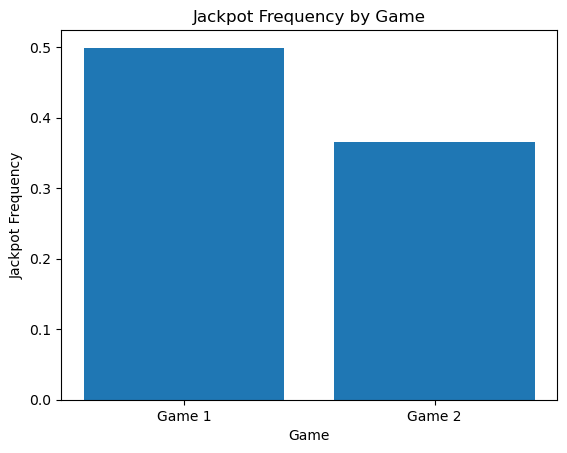

In [118]:
import matplotlib.pyplot as plt

games=['Game 1', 'Game 2']
freq=[an1.jackpot()/len(game1.show_outcome()),an2.jackpot()/len(game2.show_outcome())]

plt.bar(games,freq)
plt.xlabel("Game")
plt.ylabel("Jackpot Frequency")
plt.title("Jackpot Frequency by Game")


## Scenario 2: A 6-sided Die (9)

Task 1. Create three dice, each with six sides having the faces 1 through 6.

- Three die objects created (1).

In [46]:
die_face = np.array([1,2,3,4,5,6])
die1=s.Die(die_face)
die2=s.Die(die_face)
die3=s.Die(die_face)
die1.show_die()

,Weight
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0


In [47]:
die2.show_die()

,Weight
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0


In [48]:
die2.show_die()

,Weight
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0


Task 2. Convert one of the dice to an unfair one by weighting the face $6$ five times more than the other weights (i.e. it has weight of 5 and the others a weight of 1 each).

- Unfair die created with proper call to weight change method (1).

In [49]:
die3.change_weight(6,5)
die3.show_die()

,Weight
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,5.0


Task 3. Convert another of the dice to be unfair by weighting the face $1$ five times more than the others.

- Unfair die created with proper call to weight change method (1).

In [50]:
die2.change_weight(1,5)
die2.show_die()

,Weight
1,5.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0


Task 4. Play a game of $10000$ rolls with $5$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [38]:
die_game1=s.Game([die1,die1,die1,die1,die1])
die_game1.play(10000)
die_game1.show_outcome()

Die_Num,0,1,2,3,4
Roll_Num,,,,,
0,4,3,4,6,2
1,6,6,4,6,5
2,1,6,6,6,4
3,1,3,4,2,4
4,4,6,4,6,3
...,...,...,...,...,...
9995,6,4,6,1,3
9996,5,4,3,4,5
9997,4,3,6,6,6


Task 5. Play another game of $10000$ rolls, this time with $2$ unfair dice, one as defined in steps #2 and #3 respectively, and $3$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [39]:
die_game2=s.Game([die2,die3,die1,die1,die1])
die_game2.play(10000)
die_game2.show_outcome()

Die_Num,0,1,2,3,4
Roll_Num,,,,,
0,1,1,4,1,5
1,1,3,5,5,6
2,5,6,2,4,2
3,1,4,5,2,1
4,1,5,2,5,2
...,...,...,...,...,...
9995,1,6,5,4,1
9996,3,5,2,6,4
9997,1,2,3,6,2


Task 6. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

- Jackpot methods called (1).
- Graph produced (1).

Text(0.5, 1.0, 'Jackpot Frequency by Game')

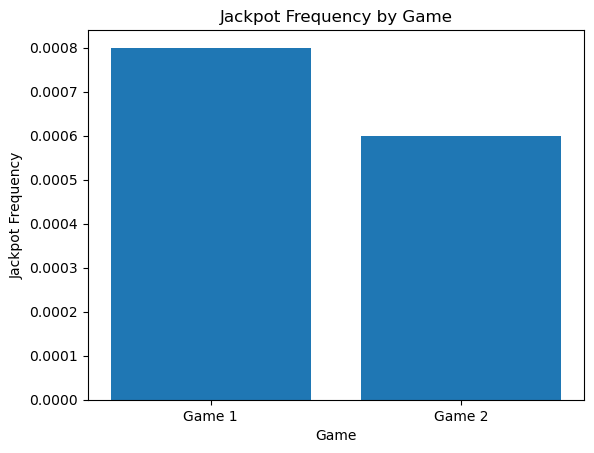

In [121]:
die_win1_freq=s.Analyzer(die_game1).jackpot()/len(die_game1.show_outcome())
die_win2_freq=s.Analyzer(die_game2).jackpot()/len(die_game2.show_outcome())

plt.bar(games,[die_win1_freq,die_win2_freq])
plt.xlabel("Game")
plt.ylabel("Jackpot Frequency")
plt.title("Jackpot Frequency by Game")


## Scenario 3: Letters of the Alphabet (7)

Task 1. Create a "die" of letters from $A$ to $Z$ with weights based on their frequency of usage as found in the data file `english_letters.txt`. Use the frequencies (i.e. raw counts) as weights.

- Die correctly instantiated with source file data (1).
- Weights properly applied using weight setting method (1).

In [61]:
letters=pd.read_csv('/home/crf6zj/Documents/MSDS/DS5100/DS5100-crf6zj-FinalProject/english_letters.txt',header=None,sep=" ")
#letters
faces=letters.iloc[:,0].values
scrab_die=s.Die(faces)
tester=('E',529117365)

for row in letters.itertuples(index=False, name=None):
    scrab_die.change_weight(row[0],row[1])


scrab_die.show_die()


,Weight
E,529117365.0
T,390965105.0
A,374061888.0
O,326627740.0
I,320410057.0
N,313720540.0
S,294300210.0
R,277000841.0
H,216768975.0
L,183996130.0


Task 2. Play a game involving $4$ of these dice with $1000$ rolls.

- Game play method properly called (1).

In [63]:
scrab_game1=s.Game([scrab_die,scrab_die,scrab_die,scrab_die])
scrab_game1.play(1000)
scrab_game1.show_outcome()

Die_Num,0,1,2,3
Roll_Num,,,,
0,H,I,S,E
1,S,G,A,W
2,I,A,L,D
3,T,R,E,T
4,N,S,B,N
...,...,...,...,...
995,D,B,R,C
996,H,E,R,N
997,T,O,E,Y


Task 3. Determine how many permutations in your results are actual English words, based on the vocabulary found in `scrabble_words.txt`.

- Use permutation method (1).
- Get count as difference between permutations and vocabulary (1).

In [109]:
with open('/home/crf6zj/Documents/MSDS/DS5100/DS5100-crf6zj-FinalProject/scrabble_words.txt', 'r') as file:
    master_words = file.read().splitlines()

words1=[]    
    
for a in s.Analyzer(scrab_game1).permutation_count().index.tolist():
    words1.append(''.join(a))

four_letter_words=len(set(master_words).intersection(set(words1)))
four_letter_words

61

Task 4. Repeat steps #2 and #3, this time with $5$ dice. How many actual words does this produce? Which produces more?

- Successfully repreats steps (1).
- Identifies parameter with most found words (1).

In [114]:
scrab_game2=s.Game([scrab_die,scrab_die,scrab_die,scrab_die,scrab_die])
scrab_game2.play(1000)
#scrab_game2.show_outcome()

words2=[]    
    
for a in s.Analyzer(scrab_game2).permutation_count().index.tolist():
    words2.append(''.join(a))

five_letter_words=len(set(master_words).intersection(set(words2)))
#five_letter_words

if four_letter_words>five_letter_words:
    print('There are more 4 letter words')
elif four_letter_words<five_letter_words:
    print('There are more 5 letter words')
else:
    print('They have the same number of words')

There are more 4 letter words
